# Finite Element Method Darcy Flow PDE

In this section of the project, we detail the process of generating data based on a physical model. Specifically, we focus on approximating the states in the Darcy Flow problem for a given set of parameters.

We begin by presenting the governing partial differential equation (PDE) associated with the Darcy Flow problem. This equation models the flow of fluid through a porous medium.

Next, we introduce the variational formulation of the PDE. This step involves translating the differential equation into a weak form, making it suitable for numerical approximation using finite element methods. We describe the key components of the variational problem, including the choice of test and trial functions, as well as the relevant boundary and initial conditions.

Finally, we specify the function spaces in which we seek solutions. These spaces must be compatible with the variational formulation and respect the regularity requirements imposed by the PDE. We discuss common function spaces used in finite element methods that ensure stability.



## Equation and problem definition

The Darcy Flow problem models the movement of fluid through a porous medium using physical principles such as mass conservation and Darcy's law. The governing equations are:

$$
\begin{align}
  v + k \nabla p &= 0 \quad {\rm in} \ \Omega, \\
  \nabla \cdot v &= 0 \quad {\rm in} \ \Omega,
\end{align}
$$

where $v$ is the Darcy velocity, p the fluid pressure, and k the permeability field of the medium.

The associated boundary conditions are:

$$
\begin{align}
  p &= 1 \quad {\rm on} \ \Gamma_{1}, \\
  p &= 0 \quad {\rm on} \ \Gamma_{2}, \\
  v \cdot n &= 0 \quad {\rm on} \ \Gamma_{3},
\end{align}
$$

where $\Gamma_1$ and $\Gamma_2$ are pressure-imposed boundaries (Dirichlet condition), while $\Gamma_3$ represents a no-flow boundary. Here $n$ denotes the outward pointing normal vector on the boundary.

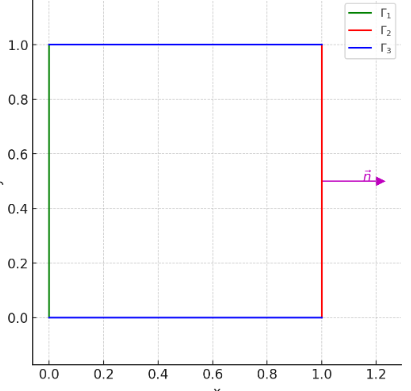

Looking at the variational form, we see that the
boundary condition for the flux ($v \cdot n = 0$) is now an essential
boundary condition (which should be enforced in the function space), while
the other boundary condition (p=0 and p=1) is a natural boundary condition
(which should be applied to the variational form). Inserting the boundary
conditions, this variational problem can be phrased in the general form: find
$(v, p) \in V \times P$ such that

$$
   a((\sigma, u), (\tau, v)) = L((\tau, v))
   \quad \forall \ (\tau, v) \in \Sigma_0 \times V,
$$

where the variational forms $a$ and $L$ are defined as

$$
\begin{align}
  a((v, p), (u, q)) &=
    \int_{\Omega} \frac{v \cdot u}{k} - p \nabla \cdot u 
  + q \nabla \cdot v  \ {\rm d} x, \\
  L((u, q)) &= - \int_{\Gamma_1} u \cdot n  \ {\rm d} s,
\end{align}
$$
and $V = \{ v \in H({\rm div})$ such that $v \cdot n|_{\Gamma_3} = 0 \}$ and $P = L^2(\Omega)$.

To discretize the above formulation, two discrete function spaces $V_h
\subset V$ and $P_h \subset P$ are needed to form a mixed function space
$V_h \times P_h$. A stable choice of finite element spaces is to let
$V_h$ be the Raviart Thomas elements of polynomial order
$k$ and let $P_h$ be Lagrange elements of polynomial order $k-1$.

These are:

* $\Omega = [0,1] \times [0,1]$ (a unit square)
* $\Gamma_{1} = \{(0, y) \in \partial \Omega\}$
* $\Gamma_{2} = \{(1, y) \in \partial \Omega\}$
* $\Gamma_{3} = \{(x, 0) \cup (x, 1) \in \partial \Omega\}$


## Implementation

!!! CODE TO RUN ON GOOGLE COLAB !!!

In [ ]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [ ]:
from dolfinx import default_real_type, fem, io, mesh, geometry
from dolfinx.fem.petsc import LinearProblem
from ufl import Measure, SpatialCoordinate, TestFunctions, TrialFunctions, div, exp, inner, FacetNormal
from basix.ufl import element, mixed_element
from mpi4py import MPI
from dolfinx.mesh import locate_entities_boundary, meshtags

import numpy as np
import math
from scipy.special import gamma, kv
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

from typing import Union

In [ ]:
class DarcyFlow:

  def __init__(self, param: dict):
     self.param = param

  def generate_data(self, nb_data: int) -> list:
    result = []

    lambda_m_sorted_n, psi_m_sorted_n = self.get_cov_m_matrix_decomp()

    for i in range(nb_data):
      v_h, p_h, k_values, msh = self.interpolation(lambda_m_sorted_n=lambda_m_sorted_n, psi_m_sorted_n=psi_m_sorted_n)
      dict_evaluation = self.evaluation(msh=msh, v_h=v_h, p_h=p_h, k_values=k_values)
      result.append(dict_evaluation)

    return result

  def evaluation(self, msh: dolfinx.mesh.Mesh, v_h: dolfinx.fem.function.Function,
                 p_h: dolfinx.fem.function.Function, k_values: np.array) -> dict:
    # Interpolation on a grid

    nb_square_eval = self.param["nb_square_eval"]
    Nx, Ny = nb_square_eval, nb_square_eval
    x_coords = np.linspace(0.0, 1.0, Nx)
    y_coords = np.linspace(0.0, 1.0, Ny)

    X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')
    points_2D = np.vstack((X.ravel(), Y.ravel())).T
    points=np.hstack((points_2D, np.zeros((points_2D.shape[0], 1))))
    bbt = geometry.bb_tree(msh, msh.topology.dim)

    cells = []
    for pt in points:

      cell_candidates = geometry.compute_collisions_points(bbt, pt)
      cell = geometry.compute_colliding_cells(msh, cell_candidates, pt)

      cells.append(cell.array[0])

    v_eval = v_h.eval(points, cells)
    p_eval = p_h.eval(points, cells)

    k_matrix = k_values
    p_matrix = p_eval[:,0].reshape((nb_square_eval, nb_square_eval))
    v_absissa_matrix = v_eval[:,0].reshape((nb_square_eval, nb_square_eval))
    v_ordinate_matrix = v_eval[:,1].reshape((nb_square_eval, nb_square_eval))

    dict_evaluation = {"k": k_matrix,
                       "p": p_matrix,
                       "v_absissa": v_absissa_matrix,
                       "v_ordinate": v_ordinate_matrix}

    return dict_evaluation

  def get_cov_m_matrix_decomp(self) -> Union[np.array, np.array]:
    # Parameters

    nb_square = self.param["nb_square"]
    nb_square_eval = self.param["nb_square_eval"]

    sigma = self.param["sigma"]
    l = self.param["l"]
    nu = self.param["nu"]

    kernel = (sigma**2)*Matern(length_scale=l, nu=nu)  # Matern kernel

    # We consider a discretized version of the log permeability field m in the unit square
    # We want to compute cov(m, m_bis) with m and m_bis values of m in the unit square

    i_coords = np.arange(nb_square_eval) / nb_square # Create a grid of points in the unit square
    j_coords = np.arange(nb_square_eval) / nb_square
    I, J = np.meshgrid(i_coords, j_coords, indexing='ij')
    X = np.column_stack([I.ravel(), J.ravel()])  # Flattened array of coordinates

    cov_m_matrix = kernel(X, X)

    lambda_m, psi_m = np.linalg.eigh(cov_m_matrix)

    idx = np.argsort(lambda_m)[::-1] # Sort eigenvalues and eigenvectors in decreasing order of eigenvalues
    lambda_m_sorted = lambda_m[idx]
    psi_m_sorted = psi_m[:, idx]

    lambda_m_sorted_n = lambda_m_sorted[:n]
    psi_m_sorted_n = psi_m_sorted[:, :n]

    return lambda_m_sorted_n, psi_m_sorted_n

  def interpolation(self, lambda_m_sorted_n: np.array, psi_m_sorted_n: np.array
                    ) -> Union[dolfinx.fem.function.Function, dolfinx.fem.function.Function, np.array, dolfinx.mesh.Mesh]:
    # Parameters

    nb_square = self.param["nb_square"]
    nb_square_eval = self.param["nb_square_eval"]

    v_element_type = self.param["v_element_type"]
    v_element_order = self.param["v_element_order"]

    p_element_type = self.param["p_element_type"]
    p_element_order = self.param["p_element_order"]

    n = self.param["n"]


    # Creation of the mesh

    msh = mesh.create_unit_square(MPI.COMM_WORLD, nb_square, nb_square, mesh.CellType.quadrilateral)
    x = SpatialCoordinate(msh)


    # Definition of function space

    Q_el = element(v_element_type, msh.basix_cell(), v_element_order, dtype=default_real_type) # Raviart-Thomas element
    P_el = element(p_element_type, msh.basix_cell(), p_element_order, dtype=default_real_type) # Lagrange element

    V_el = mixed_element([Q_el, P_el])
    V = fem.functionspace(msh, V_el) # mixed element space

    (v, p) = TrialFunctions(V) # function we are approximating v is velocity and p is pressure
    (u, q) = TestFunctions(V) # test function of v and p


    # Definition of measure(associated to an integral) in variational problem

    dx = Measure("dx", msh) # global measure

    def boundary_x0(x):
        return np.isclose(x[0], 0.0)
    facets_x0 = locate_entities_boundary(msh, msh.topology.dim - 1, boundary_x0)
    ft = meshtags(msh, msh.topology.dim-1, facets_x0, np.full_like(facets_x0, 1, dtype=np.int32))
    normal_vector = FacetNormal(msh)

    ds = Measure("ds", domain=msh, subdomain_data=ft) # measure on left border of unit square  x=0 and y=[0, 1]


    # Evaluation of permeability field k

    z = np.random.randn(n) # Generate a random vector z and construct the truncated field
    m_N_n = psi_m_sorted_n @ (np.sqrt(lambda_m_sorted_n) * z)

    m_matrix = m_N_n.reshape((nb_square_eval, nb_square_eval)) # Reshape the result into a matrix form

    k_values = np.exp(m_matrix) # Exponentiate to get the permeability field values


    # Interpolation of discrete permeability field

    P1_el = element("Lagrange", msh.basix_cell(), 1)  # Linear interpolation (order 1 polynomial)
    W = fem.functionspace(msh, P1_el)
    k_fun = fem.Function(W)

    x_dofs = W.tabulate_dof_coordinates()
    x_coords = x_dofs[:,0]
    y_coords = x_dofs[:,1]

    i_idx = np.round(x_coords * nb_square).astype(int)
    j_idx = np.round(y_coords * nb_square).astype(int)

    k_fun.x.array[:] = k_values[i_idx, j_idx]


    # Definition of bilinear and linear form

    a = (inner(v, u)/k_fun) * dx - inner(p, div(u)) * dx + inner(q, div(v)) * dx # bilinear
    L = - inner(u, normal_vector)*ds(1) # linear


    # Define condition on velocity and normal vector on Gamma_3 boundary

    V0 = V.sub(0) # subspace of velocity v

    fdim = msh.topology.dim - 1
    Q, _ = V0.collapse()

    facets_top = mesh.locate_entities_boundary(msh, fdim, lambda x: np.isclose(x[1], 1.0)) # Gamma_3 boundary top
    dofs_top = fem.locate_dofs_topological((V0, Q), fdim, facets_top)

    facets_bottom = mesh.locate_entities_boundary(msh, fdim, lambda x: np.isclose(x[1], 0.0)) # Gamma_3 boundary bottom
    dofs_bottom = fem.locate_dofs_topological((V0, Q), fdim, facets_bottom)

    def f_gamma_3(x) -> np.array:
        values = np.zeros((2, x.shape[1])) # v.n = 0 on Gamma_3 boundary
        return values

    f_h = fem.Function(Q)
    f_h.interpolate(f_gamma_3)
    bc_top = fem.dirichletbc(f_h, dofs_top, V0)
    bc_bottom = fem.dirichletbc(f_h, dofs_bottom, V0)

    bcs_ = [bc_top, bc_bottom]

    dofs_top = fem.locate_dofs_topological((V0, Q), fdim, facets_top)
    dofs_bottom = fem.locate_dofs_topological((V0, Q), fdim, facets_bottom)

    zero = fem.Function(Q)
    zero.interpolate(lambda x: np.zeros((2, x.shape[1])))

    bc_top = fem.dirichletbc(zero, dofs_top, V0)
    bc_bottom = fem.dirichletbc(zero, dofs_bottom, V0)

    bcs = [bc_top, bc_bottom]


    # Definition of our problem with boundary condition
    problem = LinearProblem(
        a,
        L,
        bcs=bcs,
        petsc_options={
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "superlu_dist",
        },
    )

    w_h = problem.solve()
    v_h, p_h = w_h.split() # approximate of v and p

    return v_h, p_h, k_values, msh

# Main code

In [ ]:
# Number of data to generate
nb_data = 10

# Mesh parameters
nb_square = 32 # number of square to create the mesh which are going to be split into triangle
nb_square_eval = 50 # number of square to evaluate our result

# Element parameters
v_element_type = "RT" # Raviart-Thomas
v_element_order = 4 # degree of polynomial interpolation

p_element_type = "Lagrange"
p_element_order = 3

# Permeability flow k parameters
n = 1089 # truncation of principal component of the paper
sigma = 0.5    # square root of variance
l = 0.2        # correlation length
nu = 1.5       # smoothness

param = {"nb_square": nb_square,
         "nb_square_eval": nb_square_eval,
         "v_element_type": v_element_type,
         "v_element_order": v_element_order,
         "p_element_type": p_element_type,
         "p_element_order": p_element_order,
         "n": n,
         "sigma": sigma,
         "l": l,
         "nu": nu}

def approx_time_to_generate(nb_data: int):
  nb_sec_total = (7+nb_data*2)
  nb_hour = nb_sec_total//3600
  nb_minute = (nb_sec_total-nb_hour*3600)//60
  nb_sec = nb_sec_total - nb_hour*3600 - nb_minute*60

  return f"{nb_hour}:{nb_minute}:{nb_sec}"

# Data Generation
print("Generation time order", approx_time_to_generate(nb_data=nb_data))

darcy_flow = DarcyFlow(param=param)
result = darcy_flow.generate_data(nb_data=nb_data) # list of dict containing matrix associated to k, p, v_absissa, v_ordinate